# Michelin Restaurants in France - *Arrondissements*

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

Importing restaurant data

In [3]:
france_data = pd.read_csv("../../data/France/all_restaurants.csv")
france_data.head()

,name,address,location,department_num,department,capital,region,price,cuisine,url,award,stars,longitude,latitude
0,La Vague d'Or - Cheval Blanc St-Tropez,Plage de la Bouillabaisse,"Saint-Tropez, 83990",83,Var,Toulon,Provence-Alpes-Côte d'Azur,€€€€,"Creative, Modern Cuisine",https://www.chevalblanc.com/fr/maison/st-tropez/,3 MICHELIN Stars,3.0,6.626154,43.266585
1,René et Maxime Meilleur,Hameau de Saint-Marcel,"Saint-Martin-de-Belleville, 73440",73,Savoie,Chambéry,Auvergne-Rhône-Alpes,€€€€,"Creative, Regional Cuisine",https://www.la-bouitte.com/fr/,3 MICHELIN Stars,3.0,6.513306,45.369046
2,Kei,5 rue du Coq-Héron,"Paris, 75001",75,Paris,Paris,Île-de-France,€€€€,"Modern Cuisine, Creative",https://www.restaurant-kei.fr/,3 MICHELIN Stars,3.0,2.342285,48.864395
3,Auberge du Vieux Puits,5 avenue Saint-Victor,"Fontjoncouse, 11360",11,Aude,Carcassonne,Occitanie,€€€€,Creative,https://www.aubergeduvieuxpuits.fr/fr/,3 MICHELIN Stars,3.0,2.789329,43.048173
4,Régis et Jacques Marcon,Larsiallas,"Saint-Bonnet-le-Froid, 43290",43,Haute-Loire,Le Puy-en-Velay,Auvergne-Rhône-Alpes,€€€€,Creative,https://www.lesmaisonsmarcon.fr/,3 MICHELIN Stars,3.0,4.434268,45.138673


In [4]:
print(france_data.columns.tolist())

['name', 'address', 'location', 'department_num', 'department', 'capital', 'region', 'price', 'cuisine', 'url', 'award', 'stars', 'longitude', 'latitude']


----
&nbsp;
Demographics data from [INSEE](https://statistiques-locales.insee.fr/#c=indicator&view=map5)

In [5]:
stats_locale = pd.read_csv("../../data/France/Demographics/arrondissements_data.csv", sep=';')
print(stats_locale.columns.tolist())

['Code', 'Libellé', 'Population municipale 2020', 'Taux de pauvreté 2020', 'Densité de population (historique depuis 1876) 2020', 'Salaire net horaire moyen 2021']


In [6]:
stats_locale = stats_locale.rename(columns={
    'Code': 'code',
    'Libellé': 'arrondissement',
    'Taux de pauvreté 2020': 'poverty_rate(%)',
    'Salaire net horaire moyen 2021': 'average_net_hourly_wage(€)',
    'Population municipale 2020': 'municipal_population',
    'Densité de population (historique depuis 1876) 2020': 'population_density(inhabitants/sq_km)',
})
stats_locale = stats_locale[['code', 'arrondissement', 'municipal_population', 'population_density(inhabitants/sq_km)',
                             'poverty_rate(%)', 'average_net_hourly_wage(€)']]
stats_locale.head()

,code,arrondissement,municipal_population,population_density(inhabitants/sq_km),poverty_rate(%),average_net_hourly_wage(€)
0,011,Belley,123405,77.9,10.2,15.3
1,012,Bourg-en-Bresse,340382,118.4,8.8,15.65
2,013,Gex,100314,247.8,12.4,15.32
3,014,Nantua,93755,104.2,15.5,14.14
4,021,Château-Thierry,70094,62.9,14,14.36


In [7]:
print(stats_locale.columns.tolist())

['code', 'arrondissement', 'municipal_population', 'population_density(inhabitants/sq_km)', 'poverty_rate(%)', 'average_net_hourly_wage(€)']


Loading in [GeoJSON data](https://github.com/gregoiredavid/france-geojson/blob/master/arrondissements-avec-outre-mer.geojson)

In [8]:
# Load the GeoJSON file
geoJSON_df = gpd.read_file('../../data/France/Geodata/arrondissements-avec-outre-mer.geojson')
geoJSON_df.head()

,code,nom,geometry
0,01001,Belley,"POLYGON ((5.12174 45.81118, 5.12665 45.81392, ..."
1,01002,Bourg-en-Bresse,"POLYGON ((4.98022 46.51520, 4.98355 46.51539, ..."
2,01003,Gex,"POLYGON ((6.06401 46.41623, 6.06730 46.41494, ..."
3,01004,Nantua,"POLYGON ((5.63746 46.33644, 5.64007 46.33884, ..."
4,02001,Château-Thierry,"POLYGON ((3.07188 49.11755, 3.07224 49.11832, ..."


In [9]:
print(geoJSON_df.columns.tolist())

['code', 'nom', 'geometry']


----
&nbsp;
### Removing *outre-mers*

In [10]:
# We leverage the format of the first two digits of the 'code' column
# where 01 - 95 represents mainland france
geoJSON_df = geoJSON_df.sort_values(by='code')
geoJSON_df = geoJSON_df[~geoJSON_df['code'].str.startswith('97')]
geoJSON_df = geoJSON_df.reset_index(drop=True)
geoJSON_df.shape

(320, 3)

In [11]:
# We again remove '97' leveraging a pattern
stats_locale = stats_locale.sort_values(by='code')
stats_locale = stats_locale[~stats_locale['code'].str.startswith('97')]
stats_locale = stats_locale.reset_index(drop=True)
stats_locale.shape

(320, 6)

It's good news the dataframes have the same length

----
&nbsp;
### Looking for discrepancies in the `nom`, `arrondissement` columns

In [12]:
set1 = set(stats_locale['arrondissement'].unique())
set2 = set(geoJSON_df['nom'].unique())
print(f"Sets equal? {set1 == set2}")

Sets equal? False


In [13]:
print("In set1 but not in set2: ", set1 - set2)
print("\nIn set2 but not in set1: ", set2 - set1)

In set1 but not in set2:  {'La Flèche', 'Le Raincy', 'La Tour-du-Pin', 'Le Havre', 'Les Andelys', 'Val-de-Briey', 'Le Blanc', 'Le Vigan', 'La Rochelle', 'Le Puy-en-Velay', "Les Sables-d'Olonne", "L'Haÿ-les-Roses", 'La Châtre', 'La Roche-sur-Yon', 'Le Mans'}

In set2 but not in set1:  {'Roche-sur-Yon', "Sables-d'Olonne", 'Havre', 'Rochelle', 'Mans', 'Vigan', 'Puy-en-Velay', 'Raincy', 'Châtre', 'Briey', 'Flèche', 'Haÿ-les-Roses', 'Andelys', 'Tour-du-Pin', 'Blanc'}


We will remove articles from the `stats_locale` DataFrame. This will not significantly affect the ability to differentiate between *arrondissements*

In [14]:
def clean_name(name):
    # Remove common prefixes/articles
    for prefix in ['Le ', 'La ', 'Les ', "L'"]:
        if name.startswith(prefix):
            name = name[len(prefix):]
    return name.strip()

In [15]:
set1_clean = set(map(clean_name, stats_locale['arrondissement'].unique()))
set2_clean = set(map(clean_name, geoJSON_df['nom'].unique()))

# Update 'stats_locale' with the new names
stats_locale['arrondissement'] = stats_locale['arrondissement'].apply(clean_name)

In [16]:
# Check for discrepancies again
print("In set1_clean but not in set2_clean: ", set1_clean - set2_clean)
print("\nIn set2_clean but not in set1_clean: ", set2_clean - set1_clean)

In set1_clean but not in set2_clean:  {'Val-de-Briey'}

In set2_clean but not in set1_clean:  {'Briey'}


In [19]:
# Correct the discrepancy manually
if 'Val-de-Briey' in set1_clean and 'Briey' in set2_clean:
    geoJSON_df['nom'] = geoJSON_df['nom'].replace('Briey', 'Val-de-Briey')

# Validating and recomparing the sets
set1_clean = set(map(clean_name, stats_locale['arrondissement'].unique()))
set2_clean = set(map(clean_name, geoJSON_df['nom'].unique()))

print("In set1_clean but not in set2_clean: ", set1_clean - set2_clean)
print("\nIn set2_clean but not in set1_clean: ", set2_clean - set1_clean)

In set1_clean but not in set2_clean:  set()

In set2_clean but not in set1_clean:  set()


----
&nbsp;
### Mapping individual restaurants to *arrondissements* based on (latitude, longitude) Geospatial data

In [20]:
# Convert france_data to GeoDataFrame
geometry = [Point(xy) for xy in zip(france_data.longitude, france_data.latitude)]
france_geo = gpd.GeoDataFrame(france_data, geometry=geometry)

In [21]:
france_geo.head()

,name,address,location,department_num,department,capital,region,price,cuisine,url,award,stars,longitude,latitude,geometry
0,La Vague d'Or - Cheval Blanc St-Tropez,Plage de la Bouillabaisse,"Saint-Tropez, 83990",83,Var,Toulon,Provence-Alpes-Côte d'Azur,€€€€,"Creative, Modern Cuisine",https://www.chevalblanc.com/fr/maison/st-tropez/,3 MICHELIN Stars,3.0,6.626154,43.266585,POINT (6.62615 43.26658)
1,René et Maxime Meilleur,Hameau de Saint-Marcel,"Saint-Martin-de-Belleville, 73440",73,Savoie,Chambéry,Auvergne-Rhône-Alpes,€€€€,"Creative, Regional Cuisine",https://www.la-bouitte.com/fr/,3 MICHELIN Stars,3.0,6.513306,45.369046,POINT (6.51331 45.36905)
2,Kei,5 rue du Coq-Héron,"Paris, 75001",75,Paris,Paris,Île-de-France,€€€€,"Modern Cuisine, Creative",https://www.restaurant-kei.fr/,3 MICHELIN Stars,3.0,2.342285,48.864395,POINT (2.34228 48.86439)
3,Auberge du Vieux Puits,5 avenue Saint-Victor,"Fontjoncouse, 11360",11,Aude,Carcassonne,Occitanie,€€€€,Creative,https://www.aubergeduvieuxpuits.fr/fr/,3 MICHELIN Stars,3.0,2.789329,43.048173,POINT (2.78933 43.04817)
4,Régis et Jacques Marcon,Larsiallas,"Saint-Bonnet-le-Froid, 43290",43,Haute-Loire,Le Puy-en-Velay,Auvergne-Rhône-Alpes,€€€€,Creative,https://www.lesmaisonsmarcon.fr/,3 MICHELIN Stars,3.0,4.434268,45.138673,POINT (4.43427 45.13867)


In [22]:
france_geo.crs = "EPSG:4326"

In [23]:
joined_data = gpd.sjoin(france_geo, geoJSON_df[['nom', 'geometry']], predicate='within', how='left')
joined_data.rename(columns={'nom': 'arrondissement'}, inplace=True)

In [24]:
# Convert the GeoDataFrame to a normal DataFrame
france_df = pd.DataFrame(joined_data)

# Drop the 'geometry' and 'index_right' columns
france_df = france_df.drop(columns=['geometry', 'index_right'])
print(france_df.columns.tolist())

['name', 'address', 'location', 'department_num', 'department', 'capital', 'region', 'price', 'cuisine', 'url', 'award', 'stars', 'longitude', 'latitude', 'arrondissement']


In [25]:
new_order = ['name', 'address', 'location', 'arrondissement', 'department_num',
             'department', 'capital', 'region', 'price', 'cuisine', 'url',
             'award', 'stars', 'longitude', 'latitude']
france_df = france_df[new_order]
france_df.head(10)

,name,address,location,arrondissement,department_num,department,capital,region,price,cuisine,url,award,stars,longitude,latitude
0,La Vague d'Or - Cheval Blanc St-Tropez,Plage de la Bouillabaisse,"Saint-Tropez, 83990",Draguignan,83,Var,Toulon,Provence-Alpes-Côte d'Azur,€€€€,"Creative, Modern Cuisine",https://www.chevalblanc.com/fr/maison/st-tropez/,3 MICHELIN Stars,3.0,6.626154,43.266585
1,René et Maxime Meilleur,Hameau de Saint-Marcel,"Saint-Martin-de-Belleville, 73440",Albertville,73,Savoie,Chambéry,Auvergne-Rhône-Alpes,€€€€,"Creative, Regional Cuisine",https://www.la-bouitte.com/fr/,3 MICHELIN Stars,3.0,6.513306,45.369046
2,Kei,5 rue du Coq-Héron,"Paris, 75001",Paris,75,Paris,Paris,Île-de-France,€€€€,"Modern Cuisine, Creative",https://www.restaurant-kei.fr/,3 MICHELIN Stars,3.0,2.342285,48.864395
3,Auberge du Vieux Puits,5 avenue Saint-Victor,"Fontjoncouse, 11360",Narbonne,11,Aude,Carcassonne,Occitanie,€€€€,Creative,https://www.aubergeduvieuxpuits.fr/fr/,3 MICHELIN Stars,3.0,2.789329,43.048173
4,Régis et Jacques Marcon,Larsiallas,"Saint-Bonnet-le-Froid, 43290",Yssingeaux,43,Haute-Loire,Le Puy-en-Velay,Auvergne-Rhône-Alpes,€€€€,Creative,https://www.lesmaisonsmarcon.fr/,3 MICHELIN Stars,3.0,4.434268,45.138673
5,Assiette Champenoise,"40 avenue Paul-Vaillant-Couturier, à Tinqueux","Reims, 51430",Reims,51,Marne,Châlons-en-Champagne,Grand Est,€€€€,Creative,https://www.assiettechampenoise.com/,3 MICHELIN Stars,3.0,4.003267,49.247835
6,Troisgros - Le Bois sans Feuilles,728 route de Villerest,"Ouches, 42155",Roanne,42,Loire,Saint-Étienne,Auvergne-Rhône-Alpes,€€€€,Creative,https://www.troisgros.com/,3 MICHELIN Stars,3.0,3.992360,46.010330
7,Le Clos des Sens,13 rue Jean-Mermoz - à Annecy-le-Vieux,"Annecy, 74940",Annecy,74,Haute-Savoie,Annecy,Auvergne-Rhône-Alpes,€€€€,Creative,https://www.closdessens.com/,3 MICHELIN Stars,3.0,6.144577,45.917632
8,La Marine,3 rue Marie-Lemonnier,"L'Herbaudière, 85330",Sables-d'Olonne,85,Vendée,La Roche-sur-Yon,Pays de la Loire,€€€€,"Creative, Seafood",https://www.alexandrecouillon.com/fr/,3 MICHELIN Stars,3.0,-2.299934,47.023710
9,La Villa Madie,Avenue de Revestel,"Cassis, 13260",Marseille,13,Bouches-du-Rhône,Marseille,Provence-Alpes-Côte d'Azur,€€€€,"Creative, Mediterranean Cuisine",https://lavillamadie.com/,3 MICHELIN Stars,3.0,5.544944,43.211089


In [26]:
france_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1033 entries, 0 to 1032
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1033 non-null   object 
 1   address         1033 non-null   object 
 2   location        1033 non-null   object 
 3   arrondissement  1033 non-null   object 
 4   department_num  1033 non-null   object 
 5   department      1033 non-null   object 
 6   capital         1033 non-null   object 
 7   region          1033 non-null   object 
 8   price           1033 non-null   object 
 9   cuisine         1033 non-null   object 
 10  url             989 non-null    object 
 11  award           1033 non-null   object 
 12  stars           1033 non-null   float64
 13  longitude       1033 non-null   float64
 14  latitude        1033 non-null   float64
dtypes: float64(3), object(12)
memory usage: 129.1+ KB


In [27]:
# Unique arrondissement in the dataset
france_df.arrondissement.nunique()

223

In [28]:
# Export the DataFrame to a .csv file
france_df.to_csv('../../data/France/all_restaurants(arrondissements).csv', index=False)

----
&nbsp;
## Grouping by *arrondissement* based on number of Michelin stars

In [29]:
france_data_copy = france_df.copy()

# Create dummy variables for each category of 'star'
france_data_copy['bib_gourmand'] = france_data_copy['stars'].apply(lambda x: 1 if x == 0.5 else 0)
france_data_copy['1_star'] = france_data_copy['stars'].apply(lambda x: 1 if x == 1.0 else 0)
france_data_copy['2_star'] = france_data_copy['stars'].apply(lambda x: 1 if x == 2.0 else 0)
france_data_copy['3_star'] = france_data_copy['stars'].apply(lambda x: 1 if x == 3.0 else 0)

#### By *`arrondissement`*
We sort `france_data` by total number of awarded restaurants

In [30]:
# Group by 'arrondissement' and sum 'bib', '1_star', '2_star' and '3_star'
arrondissement_grouped = france_data_copy.groupby('arrondissement')[['bib_gourmand', '1_star', '2_star', '3_star']].sum()

# Create a copy for plotting
arrondissement_grouped_two = arrondissement_grouped.copy()

`arrondissement_grouped` is created to be merged with the demographics data

In [31]:
# Create a 'total_ star' column - sum of stars
# Individual stars are summed here. ie, If 2 star then stars = 2
arrondissement_grouped['total_stars'] = arrondissement_grouped['1_star']*1 + arrondissement_grouped['2_star']*2 + arrondissement_grouped['3_star']*3

# Create a 'total' column = sum of restaurants
arrondissement_grouped['starred_restaurants'] =  arrondissement_grouped['1_star'] + arrondissement_grouped['2_star'] + arrondissement_grouped['3_star']

# Sort the dataframe by the 'total_stars' column in descending order
arrondissement_grouped.sort_values('total_stars', ascending=True, inplace=True)

In [32]:
arrondissement_grouped.head()

,bib_gourmand,1_star,2_star,3_star,total_stars,starred_restaurants
arrondissement,,,,,,
Abbeville,1,0,0,0,0,0
Lure,1,0,0,0,0,0
Lons-le-Saunier,1,0,0,0,0,0
Évreux,1,0,0,0,0,0
Istres,1,0,0,0,0,0


----
&nbsp;
## Plotting starred restaurants by *`arrondissement`*

We use `arrondissement_grouped_two` for plotting whilst excluding Paris

In [33]:
# Create a 'total_starred' column - sum of starred restaurants
arrondissement_grouped_two['total_starred'] = arrondissement_grouped_two['1_star'] + arrondissement_grouped_two['2_star'] + arrondissement_grouped_two['3_star']

# Sort the dataframes by the 'total' and 'total_stars' columns in descending order
arrondissement_grouped_two.sort_values('total_starred', ascending=True, inplace=True)

In [34]:
# Exclude 'Paris'
arrondissement_grouped_no_paris = arrondissement_grouped_two[arrondissement_grouped_two.index.get_level_values('arrondissement') != 'Paris']

In [35]:
# Sort by 'total_starred' in descending order and keep the top 10
arrondissement_grouped_top10 = arrondissement_grouped_no_paris.sort_values('total_starred', ascending=False).head(10)

# Drop the 'bib_gourmand' & 'total' columns
arrondissement_grouped_top10 = arrondissement_grouped_top10.drop(columns=['bib_gourmand', 'total_starred'])

# Reverse the order of the DataFrame
arrondissement_grouped_top10 = arrondissement_grouped_top10.iloc[::-1]

Plot the data

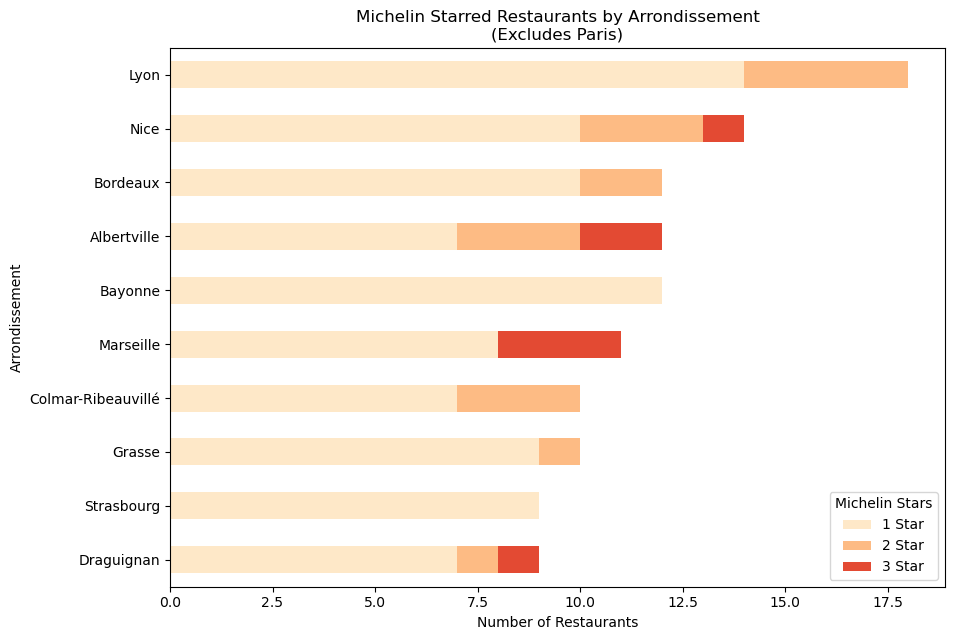

In [36]:
# Create a horizontal stacked bar plot
arrondissement_grouped_top10.plot(kind='barh', stacked=True, figsize=(10, 7),
                    color=['#fee8c8','#fdbb84','#e34a33'])

# Add title and labels
plt.title('Michelin Starred Restaurants by Arrondissement\n(Excludes Paris)')
plt.ylabel('Arrondissement')
plt.xlabel('Number of Restaurants')

# Add a legend
plt.legend(title='Michelin Stars', labels=['1 Star', '2 Star', '3 Star'])

# Show the plot
plt.show()

----
&nbsp;
#### We now cascade merges from the smallest granularity (arrondissement) up to the highest (region) using the department as an intermediary linking point.

#### 1. Extract departmental code from `geoJSON_df`

In [37]:
# Step 1: Extract department code
geoJSON_df['department_num'] = geoJSON_df['code'].str[:2]
print(f"Shape: {geoJSON_df.shape}")
print(f"Columns: {geoJSON_df.columns.tolist()}")
geoJSON_df.head(3)

Shape: (320, 4)
Columns: ['code', 'nom', 'geometry', 'department_num']


,code,nom,geometry,department_num
0,01001,Belley,"POLYGON ((5.12174 45.81118, 5.12665 45.81392, ...",01
1,01002,Bourg-en-Bresse,"POLYGON ((4.98022 46.51520, 4.98355 46.51539, ...",01
2,01003,Gex,"POLYGON ((6.06401 46.41623, 6.06730 46.41494, ...",01


#### 2. Extract department name from file produced in `France_Departments_Regions.ipynb`

In [38]:
departments = gpd.read_file("../../data/France/Geodata/departements.geojson")
print(f"Shape: {departments.shape}")
print(f"Columns: {departments.columns.tolist()}")
departments.head()

Shape: (96, 3)
Columns: ['code', 'nom', 'geometry']


,code,nom,geometry
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ..."
1,02,Aisne,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ..."
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.03424 46.79080, ..."
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ..."
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ..."


In [39]:
# Merge the dataframes on the appropriate columns
merged_geo_df = pd.merge(geoJSON_df[['code', 'nom', 'geometry', 'department_num']],
                         departments[['code', 'nom']],
                         left_on='department_num', right_on='code',
                         how='left', suffixes=('_arrondissement', '_department'))

In [40]:
print(f"Shape: {merged_geo_df.shape}")

Shape: (320, 6)


In [41]:
print(f"Columns: {merged_geo_df.columns.tolist()}")

Columns: ['code_arrondissement', 'nom_arrondissement', 'geometry', 'department_num', 'code_department', 'nom_department']


In [42]:
# Drop 'code_department'
merged_geo_df.drop('code_department', axis=1, inplace=True)

# Rename columns
column_rename_map = {
    'nom_arrondissement': 'arrondissement',
    'nom_department': 'department'
}
merged_geo_df.rename(columns=column_rename_map, inplace=True)

# Rearrange columns
new_order = ['code_arrondissement', 'arrondissement', 'department_num', 'department', 'geometry']
merged_geo_df = merged_geo_df[new_order]
merged_geo_df.head()

,code_arrondissement,arrondissement,department_num,department,geometry
0,01001,Belley,01,Ain,"POLYGON ((5.12174 45.81118, 5.12665 45.81392, ..."
1,01002,Bourg-en-Bresse,01,Ain,"POLYGON ((4.98022 46.51520, 4.98355 46.51539, ..."
2,01003,Gex,01,Ain,"POLYGON ((6.06401 46.41623, 6.06730 46.41494, ..."
3,01004,Nantua,01,Ain,"POLYGON ((5.63746 46.33644, 5.64007 46.33884, ..."
4,02001,Château-Thierry,02,Aisne,"POLYGON ((3.07188 49.11755, 3.07224 49.11832, ..."


#### 3. Extract the region from `france_df`

In [43]:
# 1. Create a copy of france_df and retain only the columns of interest
france_subset = france_df[['department_num', 'department', 'capital', 'region']].copy()

# Drop duplicates based on 'department_num'
france_subset = france_subset.drop_duplicates(subset='department_num')
print(f"Shape: {france_subset.shape}")

Shape: (92, 4)


We know from previous analysis that there are departments missing (Don't have Michelin restaurants)

Also, we know there are 96 departments. Therefore,

In [44]:
missing_dept_dict = {
    'Deux-Sèvres': {
        'department_num': '79',
        'region': 'Nouvelle-Aquitaine',
        'capital': 'Niort'
    },
    'Nièvre': {
        'department_num': '58',
        'region': 'Bourgogne-Franche-Comté',
        'capital': 'Nevers'
    },
    'Aisne': {
        'department_num': '02',
        'region': 'Hauts-de-France',
        'capital': 'Laon'
    },
    'Tarn-et-Garonne': {
        'department_num': '82',
        'region': 'Occitanie',
        'capital': 'Montauban'
    }
}

In [45]:
# Extracting data from the dictionary to lists
departments = list(missing_dept_dict.keys())
department_nums = [val['department_num'] for val in missing_dept_dict.values()]
regions = [val['region'] for val in missing_dept_dict.values()]
capitals = [val['capital'] for val in missing_dept_dict.values()]

# Creating a DataFrame from the lists
missing_dept_df = pd.DataFrame({
    'department': departments,
    'department_num': department_nums,
    'region': regions,
    'capital': capitals
})

In [46]:
# Concatenate the original dataframe with the missing departments dataframe
france_subset = pd.concat([france_subset, missing_dept_df])

# Sort by 'department_num'
france_subset = france_subset.sort_values(by='department_num').reset_index(drop=True)

In [47]:
print(f"Shape: {france_subset.shape}")
france_subset.head()

Shape: (96, 4)


,department_num,department,capital,region
0,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes
1,02,Aisne,Laon,Hauts-de-France
2,03,Allier,Moulins,Auvergne-Rhône-Alpes
3,04,Alpes-de-Haute-Provence,Digne-les-Bains,Provence-Alpes-Côte d'Azur
4,05,Hautes-Alpes,Gap,Provence-Alpes-Côte d'Azur


In [48]:
france_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   department_num  96 non-null     object
 1   department      96 non-null     object
 2   capital         96 non-null     object
 3   region          96 non-null     object
dtypes: object(4)
memory usage: 3.1+ KB


#### 4. Merge `france_subset` with `geoJSON_df` on `department_num`

In [49]:
merged_df = pd.merge(france_subset, geoJSON_df, on="department_num", how="inner")

print(f"Shape geo: {geoJSON_df.shape}\nShape merged: {merged_df.shape}")

Shape geo: (320, 4)
Shape merged: (320, 7)


In [50]:
merged_df.head()

,department_num,department,capital,region,code,nom,geometry
0,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,01001,Belley,"POLYGON ((5.12174 45.81118, 5.12665 45.81392, ..."
1,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,01002,Bourg-en-Bresse,"POLYGON ((4.98022 46.51520, 4.98355 46.51539, ..."
2,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,01003,Gex,"POLYGON ((6.06401 46.41623, 6.06730 46.41494, ..."
3,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,01004,Nantua,"POLYGON ((5.63746 46.33644, 5.64007 46.33884, ..."
4,02,Aisne,Laon,Hauts-de-France,02001,Château-Thierry,"POLYGON ((3.07188 49.11755, 3.07224 49.11832, ..."


#### 5. Merge above with `stats_locale` on 'nom' & 'arrondissement'

In [51]:
print(f"Shape: {stats_locale.shape}")
stats_locale.head()

Shape: (320, 6)


,code,arrondissement,municipal_population,population_density(inhabitants/sq_km),poverty_rate(%),average_net_hourly_wage(€)
0,011,Belley,123405,77.9,10.2,15.3
1,012,Bourg-en-Bresse,340382,118.4,8.8,15.65
2,013,Gex,100314,247.8,12.4,15.32
3,014,Nantua,93755,104.2,15.5,14.14
4,021,Château-Thierry,70094,62.9,14,14.36


In [52]:
geo_stats = pd.merge(stats_locale, merged_df, left_on='arrondissement', right_on='nom', how='inner')

In [53]:
print(f"Shape: {geo_stats.shape}")
print(f"Unique regions: {geo_stats['region'].nunique()}")
print(f"Unique departments: {geo_stats['department_num'].nunique()}")
print(f"Unique arrondissements: {geo_stats['arrondissement'].nunique()}")
print(f"Columns:\n{geo_stats.columns.tolist()}")

Shape: (320, 13)
Unique regions: 13
Unique departments: 96
Unique arrondissements: 320
Columns:
['code_x', 'arrondissement', 'municipal_population', 'population_density(inhabitants/sq_km)', 'poverty_rate(%)', 'average_net_hourly_wage(€)', 'department_num', 'department', 'capital', 'region', 'code_y', 'nom', 'geometry']


In [54]:
# Drop 'code_'
geo_stats.drop(['code_x', 'code_y'], axis=1, inplace=True)

In [55]:
# Rearrange columns
new_order = ['arrondissement', 'department_num', 'department', 'capital', 'region', 'municipal_population', 'population_density(inhabitants/sq_km)', 'poverty_rate(%)', 'average_net_hourly_wage(€)', 'geometry']
geo_stats = geo_stats[new_order]
geo_stats.head()

,arrondissement,department_num,department,capital,region,municipal_population,population_density(inhabitants/sq_km),poverty_rate(%),average_net_hourly_wage(€),geometry
0,Belley,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,123405,77.9,10.2,15.3,"POLYGON ((5.12174 45.81118, 5.12665 45.81392, ..."
1,Bourg-en-Bresse,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,340382,118.4,8.8,15.65,"POLYGON ((4.98022 46.51520, 4.98355 46.51539, ..."
2,Gex,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,100314,247.8,12.4,15.32,"POLYGON ((6.06401 46.41623, 6.06730 46.41494, ..."
3,Nantua,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,93755,104.2,15.5,14.14,"POLYGON ((5.63746 46.33644, 5.64007 46.33884, ..."
4,Château-Thierry,02,Aisne,Laon,Hauts-de-France,70094,62.9,14,14.36,"POLYGON ((3.07188 49.11755, 3.07224 49.11832, ..."


----
&nbsp;
## Merging Michelin Star by *arrondissement* with `geo_stats`

In [56]:
print(f"Rows in `geo_stats`: {len(geo_stats)}")

# We index the multi-indexed df
arrondissement_grouped.reset_index(inplace=True)
print(f"Rows in `arrondissement_grouped`: {len(arrondissement_grouped)}")

Rows in `geo_stats`: 320
Rows in `arrondissement_grouped`: 223


In [57]:
set1 = set(arrondissement_grouped['arrondissement'].unique())
set2 = set(geo_stats['arrondissement'].unique())
print(f"Sets equal? {set1 == set2}")

print(f"\nIn arrondissement_grouped but not in geo_stats:\n{set1 - set2}")
print(f"\nIn geostats but not in arrondissement_grouped:\n{set2 - set1}")

Sets equal? False

In arrondissement_grouped but not in geo_stats:
set()

In geostats but not in arrondissement_grouped:
{'Mirande', 'Avranches', 'Palaiseau', 'Millau', 'Brioude', 'Val-de-Briey', 'Montauban', 'Commercy', 'Flèche', 'Lesparre-Médoc', 'Beauvais', 'Saint-Quentin', "Saint-Jean-d'Angély", 'Melun', 'Ussel', 'Oloron-Sainte-Marie', 'Langres', 'Saint-Dié-des-Vosges', 'Segré', 'Bar-sur-Aube', 'Thiers', 'Vigan', 'Clamecy', 'Marmande', 'Avesnes-sur-Helpe', 'Corte', 'Péronne', 'Douai', 'Tarbes', 'Bastia', 'Rochechouart', 'Cosne-Cours-sur-Loire', 'Château-Gontier', 'Castelsarrasin', 'Montbéliard', 'Toul', 'Limoux', 'Provins', 'Saint-Dizier', 'Pithiviers', 'Saint-Omer', 'Lodève', 'Châtre', 'Amiens', 'Laon', 'Riom', 'Fougères-Vitré', 'Château-Thierry', 'Château-Chinon (Ville)', 'Bellac', 'Mauriac', 'Raincy', 'Nérac', 'Bressuire', 'Saint-Claude', 'Vouziers', 'Lens', 'Châtellerault', 'Foix', 'Nogent-sur-Seine', 'Saint-Amand-Montrond', 'Antony', 'Villeneuve-sur-Lot', 'Soissons', 'Nogent-l

There are a number of *arrondissement* without Michelin rated restaurants.

These will be written with zero values

In [58]:
print(f"Columns: {arrondissement_grouped.columns.tolist()}")
arrondissement_grouped.head()

Columns: ['arrondissement', 'bib_gourmand', '1_star', '2_star', '3_star', 'total_stars', 'starred_restaurants']


,arrondissement,bib_gourmand,1_star,2_star,3_star,total_stars,starred_restaurants
0,Abbeville,1,0,0,0,0,0
1,Lure,1,0,0,0,0,0
2,Lons-le-Saunier,1,0,0,0,0,0
3,Évreux,1,0,0,0,0,0
4,Istres,1,0,0,0,0,0


In [59]:
# Extracting the missing arrondissements
missing_arrondissements = list(set2 - set1)

# Prepare a list to collect new rows
new_rows = []

# Iterate over the missing arrondissements
for arrondissement in missing_arrondissements:
    new_row = {
        'arrondissement': arrondissement,
        'bib_gourmand': 0,
        '1_star': 0,
        '2_star': 0,
        '3_star': 0,
        'total_stars': 0,
        'starred_restaurants': 0
    }
    new_rows.append(new_row)

# Create a DataFrame from the new rows and concatenate with the original DataFrame
df_new_rows = pd.DataFrame(new_rows)
arrondissement_grouped = pd.concat([arrondissement_grouped, df_new_rows], ignore_index=True)

# Sorting by 'arrondissement' for better clarity
arrondissement_grouped = arrondissement_grouped.sort_values('arrondissement').reset_index(drop=True)

In [60]:
print(f"Shape: {arrondissement_grouped.shape}")
arrondissement_grouped.head()

Shape: (320, 7)


,arrondissement,bib_gourmand,1_star,2_star,3_star,total_stars,starred_restaurants
0,Abbeville,1,0,0,0,0,0
1,Agen,2,2,0,0,2,2
2,Aix-en-Provence,2,8,0,0,8,8
3,Ajaccio,1,0,0,0,0,0
4,Albertville,3,7,3,2,19,12


In [61]:
set1 = set(arrondissement_grouped['arrondissement'].unique())
set2 = set(geo_stats['arrondissement'].unique())
print(f"Sets equal? {set1 == set2}")

Sets equal? True


----
&nbsp;
## Merging `geo_stats` and `arrondissement_grouped` on 'arrondissement'

In [62]:
merged_data = pd.merge(geo_stats, arrondissement_grouped, on='arrondissement', how='inner')
print(f"Shape: {merged_data.shape}")
print(f"Columns:\n{merged_data.columns.tolist()}")

Shape: (320, 16)
Columns:
['arrondissement', 'department_num', 'department', 'capital', 'region', 'municipal_population', 'population_density(inhabitants/sq_km)', 'poverty_rate(%)', 'average_net_hourly_wage(€)', 'geometry', 'bib_gourmand', '1_star', '2_star', '3_star', 'total_stars', 'starred_restaurants']


In [63]:
new_order = ['arrondissement', 'department_num', 'department', 'capital', 'region', 'bib_gourmand', '1_star', '2_star', '3_star', 'total_stars', 'starred_restaurants', 'municipal_population', 'population_density(inhabitants/sq_km)', 'poverty_rate(%)', 'average_net_hourly_wage(€)', 'geometry']
merged_data = merged_data[new_order]
merged_data.head()

,arrondissement,department_num,department,capital,region,bib_gourmand,1_star,2_star,3_star,total_stars,starred_restaurants,municipal_population,population_density(inhabitants/sq_km),poverty_rate(%),average_net_hourly_wage(€),geometry
0,Belley,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,0,1,0,0,1,1,123405,77.9,10.2,15.3,"POLYGON ((5.12174 45.81118, 5.12665 45.81392, ..."
1,Bourg-en-Bresse,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,5,2,0,1,5,3,340382,118.4,8.8,15.65,"POLYGON ((4.98022 46.51520, 4.98355 46.51539, ..."
2,Gex,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,0,1,0,0,1,1,100314,247.8,12.4,15.32,"POLYGON ((6.06401 46.41623, 6.06730 46.41494, ..."
3,Nantua,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,1,0,0,0,0,0,93755,104.2,15.5,14.14,"POLYGON ((5.63746 46.33644, 5.64007 46.33884, ..."
4,Château-Thierry,02,Aisne,Laon,Hauts-de-France,0,0,0,0,0,0,70094,62.9,14,14.36,"POLYGON ((3.07188 49.11755, 3.07224 49.11832, ..."


----
&nbsp;
## Adding coordinates of individual restaurants

In [64]:
print(france_df.columns.tolist())

['name', 'address', 'location', 'arrondissement', 'department_num', 'department', 'capital', 'region', 'price', 'cuisine', 'url', 'award', 'stars', 'longitude', 'latitude']


In [65]:
# Create a separate DataFrame with star ratings, regions, and coordinates
location_data_arrond = france_df[['stars', 'arrondissement', 'latitude', 'longitude']]

# Convert to a dictionary where keys are tuples of star rating and arrondissement
location_dict_arrond = location_data_arrond.groupby(['stars', 'arrondissement']).apply(lambda df: list(zip(df.latitude, df.longitude))).to_dict()

In [66]:
# Now create a function to map these dictionaries to original DataFrame
def map_locations_arrond(row):
    return {stars: location_dict_arrond.get((stars, row['arrondissement'])) for stars in [1, 2, 3]}

In [67]:
merged_data['locations'] = merged_data.apply(map_locations_arrond, axis=1)

In [68]:
merged_data.head()

,arrondissement,department_num,department,capital,region,bib_gourmand,1_star,2_star,3_star,total_stars,starred_restaurants,municipal_population,population_density(inhabitants/sq_km),poverty_rate(%),average_net_hourly_wage(€),geometry,locations
0,Belley,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,0,1,0,0,1,1,123405,77.9,10.2,15.3,"POLYGON ((5.12174 45.81118, 5.12665 45.81392, ...","{1: [(46.0070045, 5.3605085)], 2: None, 3: None}"
1,Bourg-en-Bresse,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,5,2,0,1,5,3,340382,118.4,8.8,15.65,"POLYGON ((4.98022 46.51520, 4.98355 46.51539, ...","{1: [(46.4340961, 4.9390332), (46.2987913, 4.8..."
2,Gex,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,0,1,0,0,1,1,100314,247.8,12.4,15.32,"POLYGON ((6.06401 46.41623, 6.06730 46.41494, ...","{1: [(46.3626315, 6.0258533)], 2: None, 3: None}"
3,Nantua,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,1,0,0,0,0,0,93755,104.2,15.5,14.14,"POLYGON ((5.63746 46.33644, 5.64007 46.33884, ...","{1: None, 2: None, 3: None}"
4,Château-Thierry,02,Aisne,Laon,Hauts-de-France,0,0,0,0,0,0,70094,62.9,14,14.36,"POLYGON ((3.07188 49.11755, 3.07224 49.11832, ...","{1: None, 2: None, 3: None}"


----
Export as GeoJSON file

In [69]:
# Export the GeoDataFrame to a .geojson file
geo_merged_data = gpd.GeoDataFrame(merged_data, geometry='geometry')
geo_merged_data.to_file('../../data/France/arrondissement_restaurants.geojson', driver='GeoJSON')